### Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

#### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Import Libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

### Loading data

In [2]:
# loading the dataset
data = pd.read_excel("Credit+Card+Customer+Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [4]:
df = data.copy()

<IPython.core.display.Javascript object>

### Data Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

- There are 7 columns. All are integers and there are no null values

In [6]:
df.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [7]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<IPython.core.display.Javascript object>

### Statistical Summary of Numerical Columns

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

- Avg_Credit_Limit - Average Credit Limit is 34,574, medium credit limit is 18,000. Data is right skewed. Maximum average credit limit is 200,000
- Total_Credit_Cards - Custumers have average of 4.7 cars. Minimim credit card is 1 and maximum is 10
- Total_visits_bank - Average number of bank visit is 2.4. Some customers never visited bank and maximum visit is 5 in a year
- Total_visits_online - Average number of online visit is 2.6. Some customers never logged online and maximum online visit is 15
- Total_calls_made - Customers made average of 3.58 calls. Some customers did not make any calls. Maximum calls are 10 in year

### Univariate analysis

In [9]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(6, 4), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

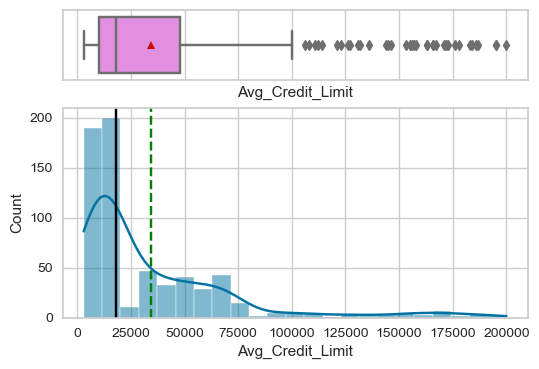

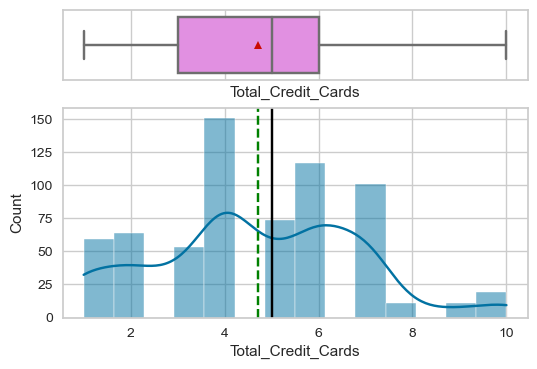

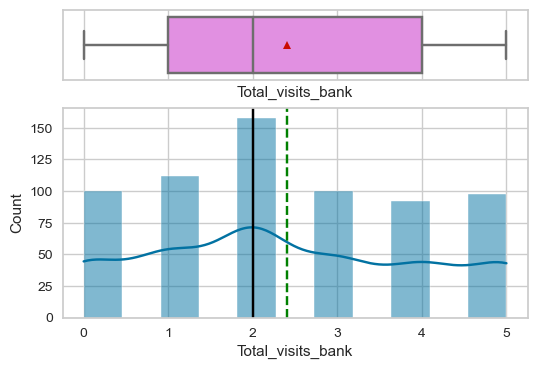

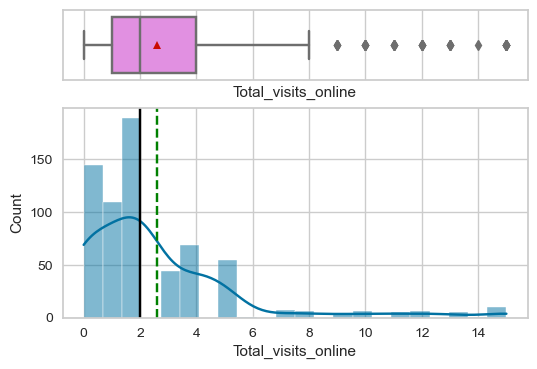

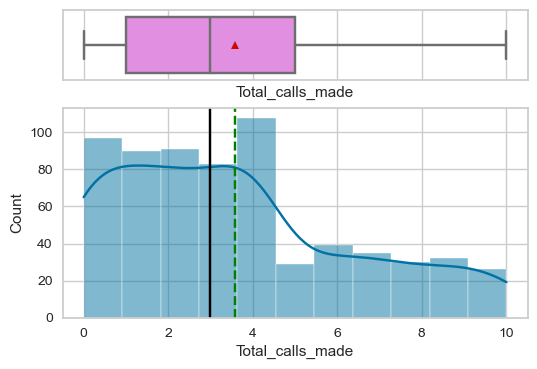

<IPython.core.display.Javascript object>

In [10]:
# selecting numerical columns
num_cols = [
    "Avg_Credit_Limit",
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made",
]

for item in num_cols:
    histogram_boxplot(df, item, kde=True)

**Observations**
- Avg_credit_limit is right skewed with long tail. Outliers have higher than 100K credit limit
- Total_credit_cards distribution is bimodal with peaks around 4 and 6 cards
- Most of the customers have visited 2 times to the bank. Other visits are uniformly distributed
- Online visit is right skewed. There are customers who have visited more than 8 and are outliers
- Majority of customers have made between 0 to 4 calls

### Bivariate analysis

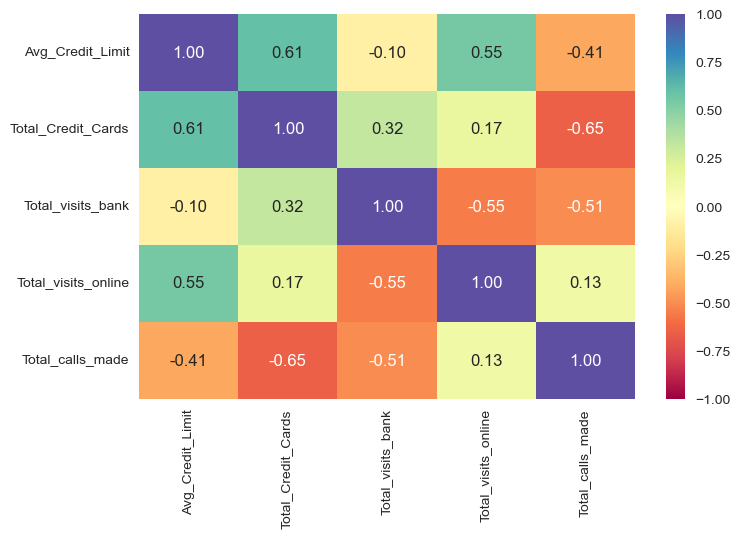

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

**Observations**
- Total number of Credit Cards is positively correlated to Average credit limit. Total number of online Visit is also positively correlated to Average Credit Limit
- Total Calls made is negatively correlated to Average Credit limit, total number of credit cards and Total visit to banks. 
- Also Total visit to the bank is negatively correlated to total number of ban visits and slightly negatively correlated to Average Credit Limit and positively correlated to total credit cards

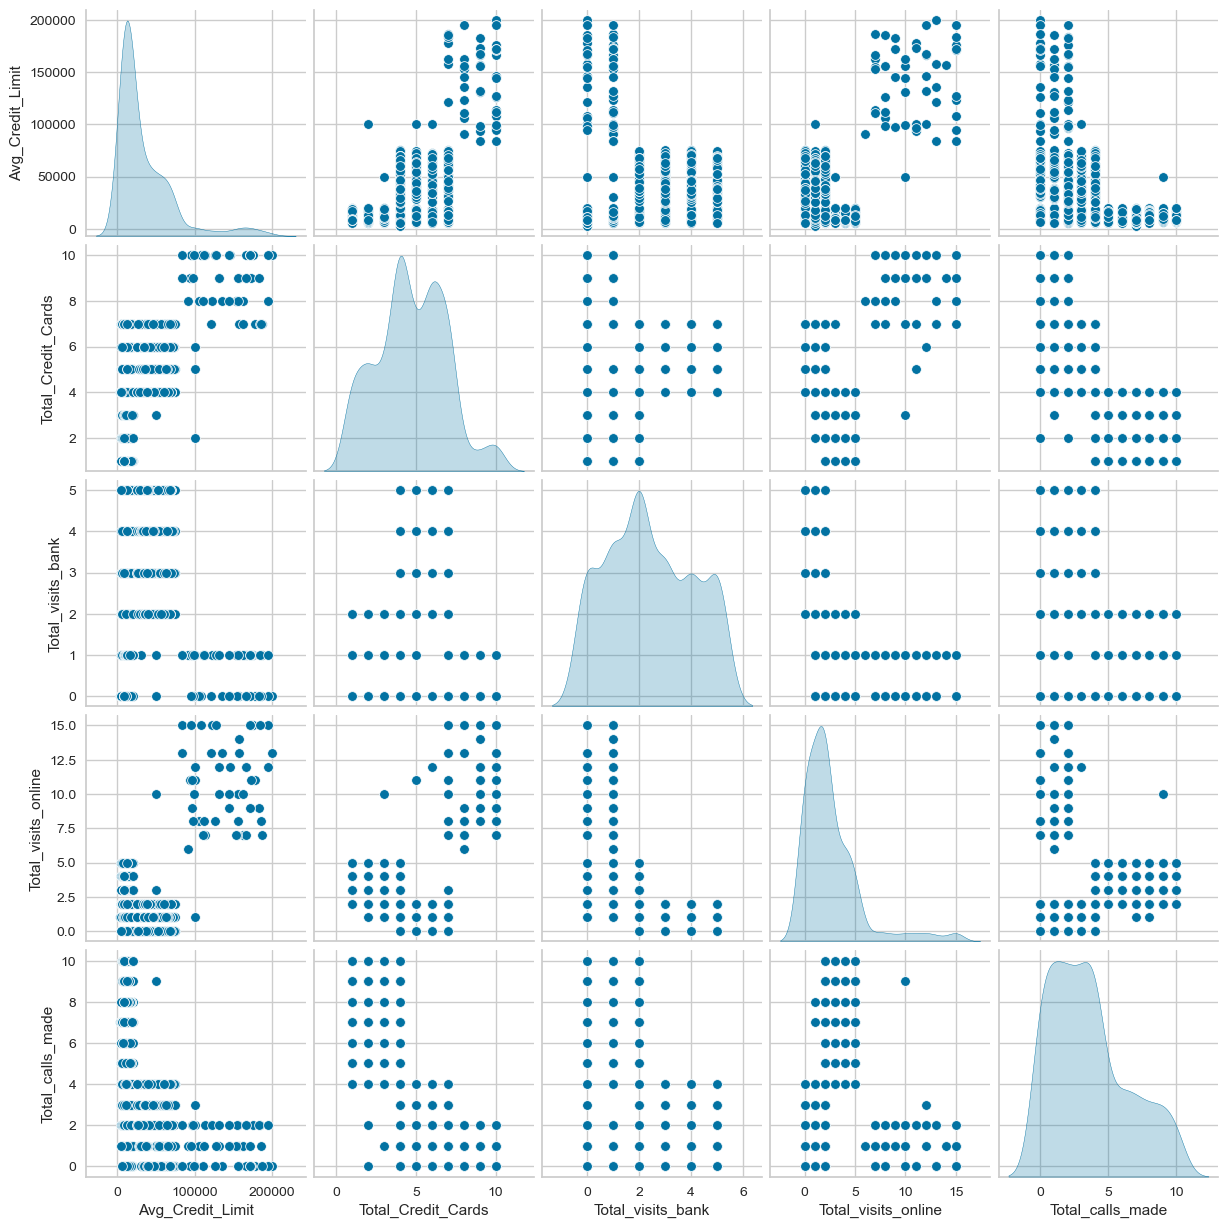

<IPython.core.display.Javascript object>

In [12]:
sns.pairplot(data=df[num_cols], diag_kind="kde")
plt.show()

**Observations**
- Total number of online visits is also positively correlated to total number of credit cards 
- Total visits online and Avg credit limit plot clearly shows 2 clusters, similarly total visits online and total credit cards shows 2 clusters
- Individual histograms for total credit cards and total bank visits clearly shows multiple groups of data

### Data preprocessing

Drop Sl_No which is sequence number

In [13]:
df.drop("Sl_No", axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Check for duplicate rows

In [14]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

- There are no duplicate rows

In [15]:
# df.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### Check for missing Values

In [16]:
df.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values

#### Checking for Outliers

In [17]:
# to find the 25th percentile and 75th percentile for the numerical columns
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)

# Inter Quantile Range (75th percentile - 25th percentile)
IQR = Q3 - Q1

# Finding lower and upper bounds for all values. All values outside these bounds are outliers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Percentage of outliers in each column
(
    ((df[num_cols] < lower_whisker) | (df[num_cols] > upper_whisker)).sum()
    / df.shape[0]
    * 100
).sort_values(ascending=False)

Avg_Credit_Limit       5.909091
Total_visits_online    5.606061
Total_Credit_Cards     0.000000
Total_visits_bank      0.000000
Total_calls_made       0.000000
dtype: float64

<IPython.core.display.Javascript object>

We are not going to treat outliers since these are valid values. 

#### Applying Standard Scaler before applying clustering models

In [18]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_cols].copy()
subset_scaled = scaler.fit_transform(subset)

# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

In [19]:
# saving original dataframes for Hierarchical clustering later
df_hca = df.copy()
subset_scaled_df_hca = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

In [20]:
df_hca.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,87073,100000,2,1,1,0
1,38414,50000,3,0,10,9
2,17341,50000,7,1,3,4
3,40496,30000,5,1,1,4
4,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [21]:
subset_scaled_df_hca.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

### Applying K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430693962124551
Number of Clusters: 7 	Average Distortion: 0.9095295671374429
Number of Clusters: 8 	Average Distortion: 0.8900319826978499


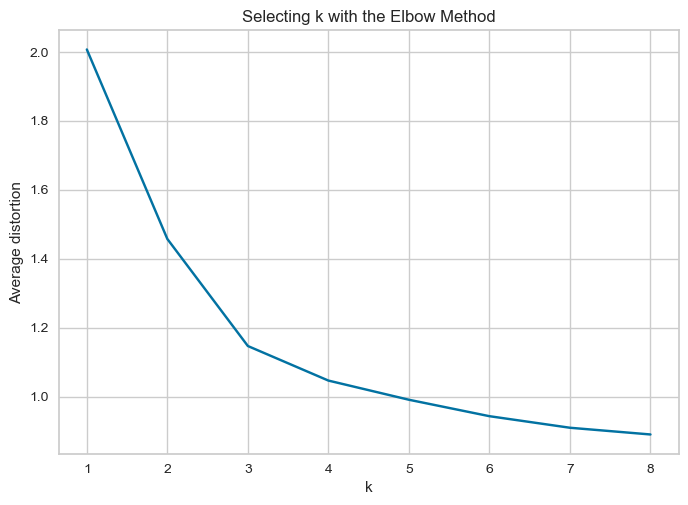

<IPython.core.display.Javascript object>

In [22]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Elbow is seen at K 3, checking silhouette score**

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2726898791817692)
For n_clusters = 6, the silhouette score is 0.2555664245735077)
For n_clusters = 7, the silhouette score is 0.24847787091758058)
For n_clusters = 8, the silhouette score is 0.22743945369989083)
For n_clusters = 9, the silhouette score is 0.21411542140077303)


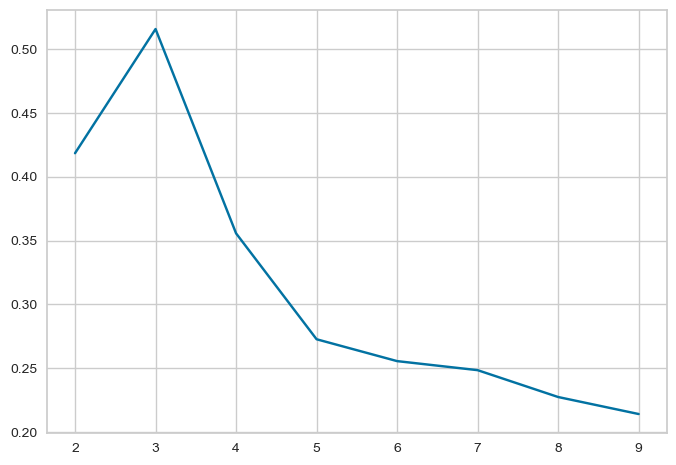

<IPython.core.display.Javascript object>

In [23]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 3 is highest. So, we will choose 3 as value of k.**

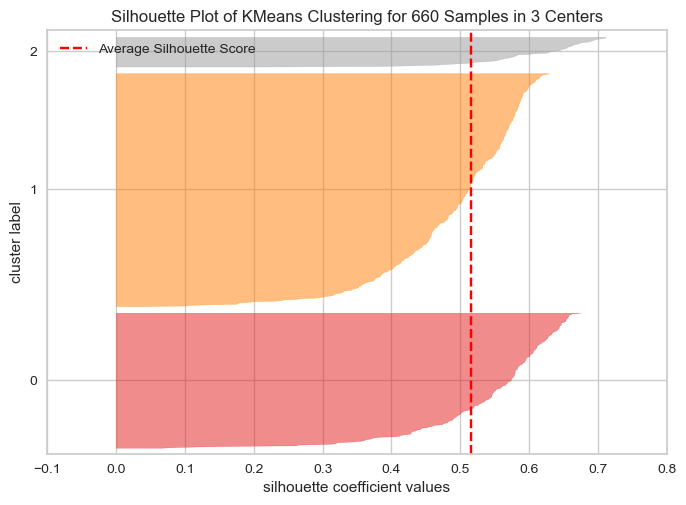

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [24]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [25]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

In [26]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

#### Cluster Profiling

In [27]:
cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [28]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Total_visits_bank"].count().values
)

<IPython.core.display.Javascript object>

In [29]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,,
0,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

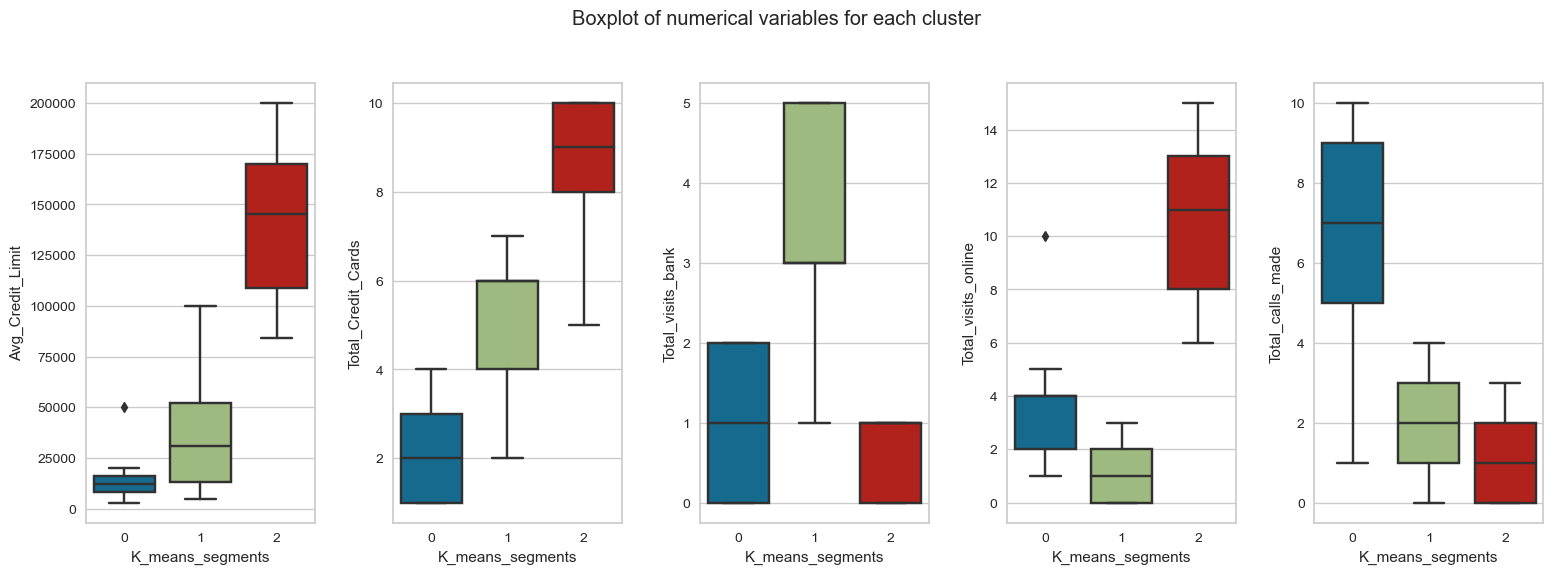

<IPython.core.display.Javascript object>

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_cols[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights from KMeans

- **Cluster 0**:
    - This cluster contains customers with lower credit limit, median is around 12K-13K
    - Total number of credit cards are between 1-3, with median 2
    - Number of bank visit varies between 0 and 2
    - Online visit varies between 2 and 4
    - Total calls made is higest
   
- **Cluster 1**:
    - Average credit limit varies between 13K to 50K
    - Total number of cards varies between 4 and 6
    - They visit banks most
    - Their online visits are lowest
    - medium calls to bank
    
- **Cluster 2**:
    - Average credit limit is highest, most of them are higher than 100K
    - They have highest number of credit cards
    - They hardly visit bank and online visit is highest
    - lowest call to bank

### Applying Hierarchical Clustering

In [31]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df_hca, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df_hca))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553607.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875355.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

<IPython.core.display.Javascript object>

In [32]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**Exploring different linkage methods with Euclidean distance.**

In [33]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df_hca, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df_hca))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [34]:
# printing linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**

- The cophenetic correlation with Euclidean distance and average linkage is highest

**Let's see the dendrograms for the different linkage methods.**

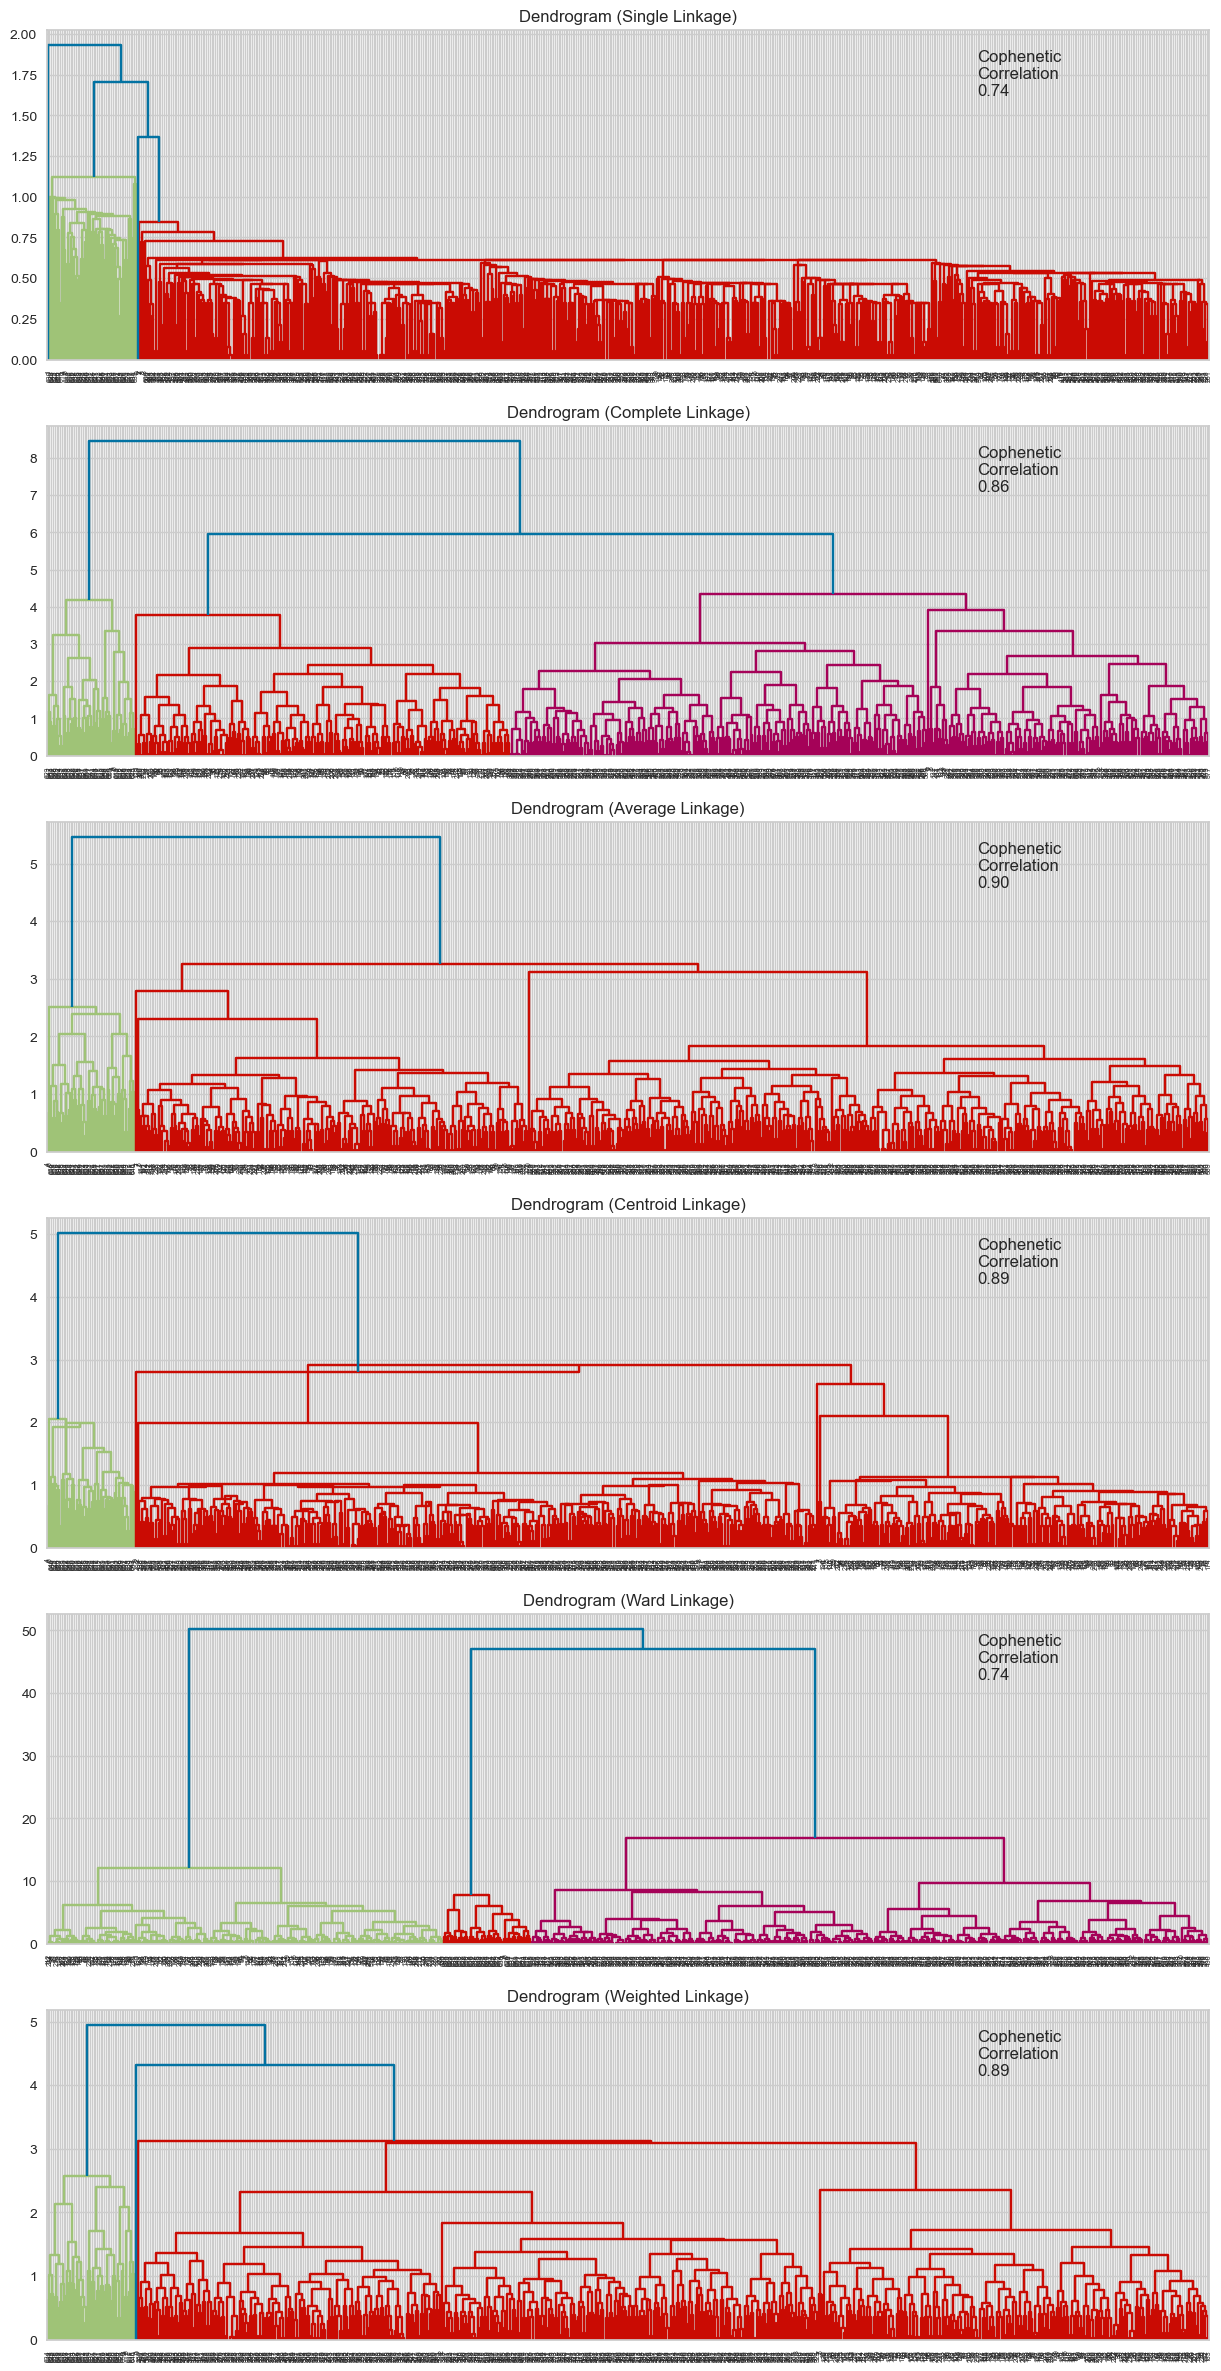

<IPython.core.display.Javascript object>

In [35]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df_hca, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df_hca))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observations**

- Dendrogram for Ward linkage shows distinct and separate clusters.
- Also Dendrogram hight is max for 3 clusters

In [36]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739122
1,complete,0.859973
2,average,0.897708
3,centroid,0.893939
4,ward,0.741516
5,weighted,0.886175


<IPython.core.display.Javascript object>

Let's see the dendrogram for Mahalanobis and Manhattan distances with average and weighted linkage methods (as they gave high cophenetic correlation values).

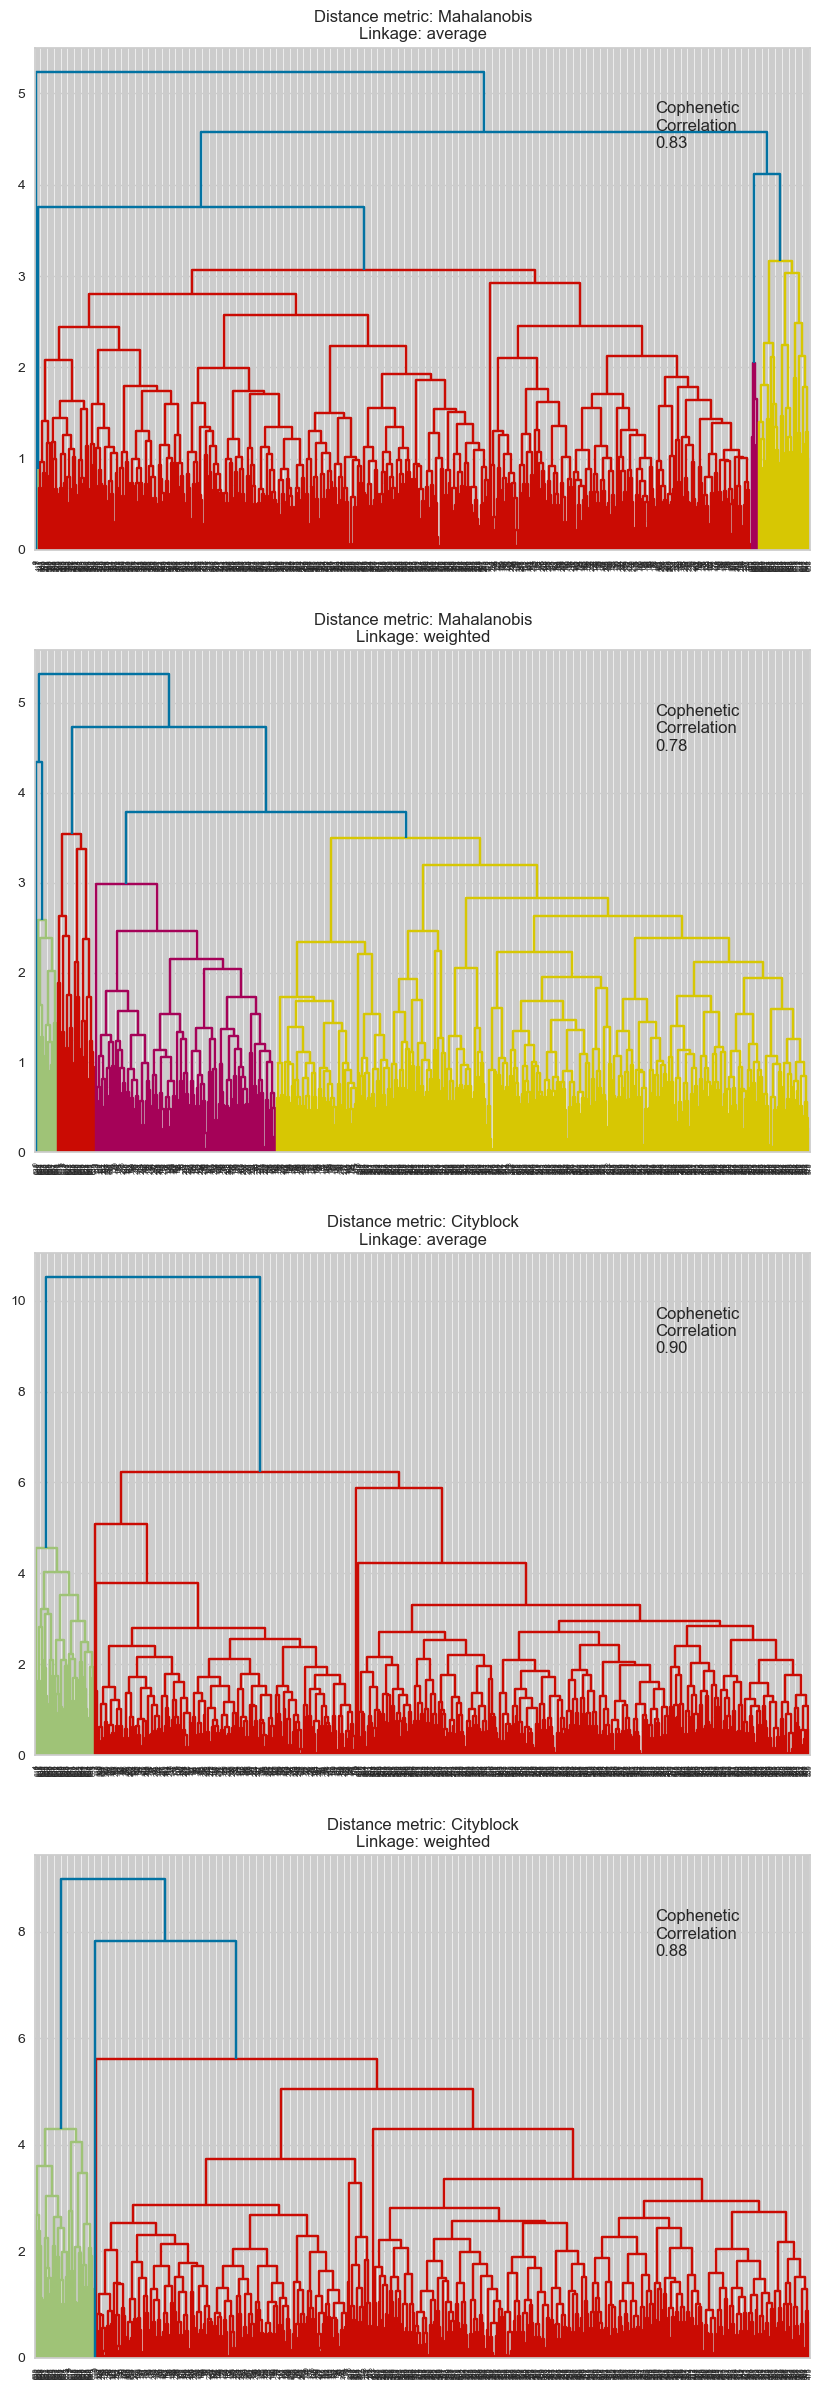

<IPython.core.display.Javascript object>

In [37]:
# list of distance metrics
distance_metrics = ["mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df_hca, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df_hca))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with Ward linkage gave us separate and distinct clusters.
- 3 would be the appropriate number of the clusters from the dendrogram with Ward linkage method. 

In [38]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df_hca)

AgglomerativeClustering(n_clusters=3)

<IPython.core.display.Javascript object>

In [39]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df_hca["HC_Clusters"] = HCmodel.labels_
df_hca["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [40]:
cluster_profile_hca = df_hca.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [41]:
cluster_profile_hca["count_in_each_segments"] = (
    df_hca.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

<IPython.core.display.Javascript object>

In [42]:
# let's display cluster profiles
cluster_profile_hca.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,,
0,54895.745455,33851.948052,5.516883,3.493506,0.979221,1.994805,385
1,55213.568889,12151.111111,2.422222,0.937778,3.546667,6.857778,225
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

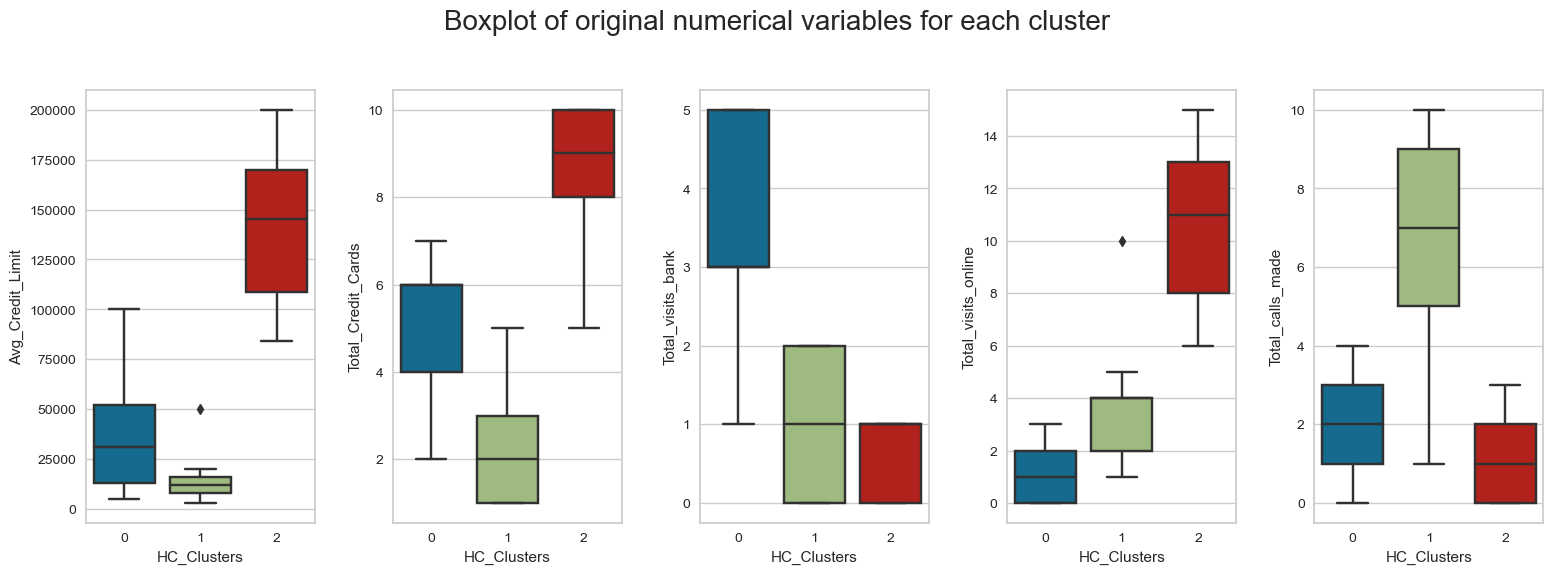

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_hca[num_cols[counter]], x=df_hca["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights from HCA

- **Cluster 0**:
    - Average credit limit varies between 13K to 50K
    - Total number of cards varies between 4 and 6
    - They visit banks most
    - Their online visits are lowest
    - medium calls to bank
   
- **Cluster 1**:
    - This cluster contains customers with lower credit limit, median is around 12K-13K
    - Total number of credit cards are between 1-3, with median 2
    - Number of bank visit varies between 0 and 2
    - Online visit varies between 2 and 4
    - Total calls made is higest
    
- **Cluster 2**:
    - Average credit limit is highest, most of them are higher than 100K
    - They have highest number of credit cards
    - They hardly visit bank and online visit is highest
    - lowest call to bank

### K-means vs Hierarchical Clustering
- Both K Means and HCA gave similar results, other than swapping the cluster 0 and 1, also difference of 1 row
- For HCA dendrograms took slightly longer time to run compared to KMeans
- In HCA, dendrograms are very good way to identify the number of clusters

### Recommendations
- Cluster 2 customers have highest credit limit and they are more likely to have more credit cards. They can be offered more cards. They like to operate more online, so bank should provide them with world class online facilities. 
- Cluster 1 (based on HCA) have lowest credit limits and they don't have many cards. These types of customers, don't have many credit cards, so if customer already have credit cards, then there is less chance of taking more cards. 
- Cluster 0 (based on HCA) are frequent visitors of bank, so bank should provide them with good experience at the banks and provide good plans at the banks